<a href="https://colab.research.google.com/github/koad7/uol_final/blob/main/FINAL_UOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install -q  transformers
!pip install -q nltk node2vec
!pip install -q haversine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.5 MB/s eta 0:00:00


In [1]:
from pathlib import Path
from google.colab import drive
import os
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import requests
import pickle
import copy
import numpy as np
import gc

In [2]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/data/')
FINAL_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/data/final_work')
WORKDIR_DIR=Path('/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/f_work/')

In [4]:
what = 'read'
if what == 'read':
  train_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/train_10_15.parquet')
  test_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/test_10_15.parquet')
  val_10_15 = pd.read_parquet(f'{FINAL_DIR}/training_testing_val_10_15_20_25_40_50_80_90/val_10_15.parquet')


In [81]:
train_df = train_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]][:70]
val_df = val_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]][:15]
test_df = val_10_15[[ 'country',
        'location','location_latitude',
       'location_longitude',  'osm_id',  'region',  'sub_region' ]][:15]

# Generate the knowledge graph

In [82]:
def create_knowledge_graph(df):
    G = nx.DiGraph()

    for idx, row in df.iterrows():
        country = row['country']
        location = row['location']
        location_latitude = row['location_latitude']
        location_longitude = row['location_longitude']
        osm_id = row['osm_id']
        region = row['region']
        sub_region = row['sub_region']


        # Add nodes
        if pd.notna(country) and country!= '':
            G.add_node(country, country=country, type='Country')
        if pd.notna(location) and location!= '':
            G.add_node(location, location=location, type='Location', osm_id=osm_id)
        if pd.notna(location_latitude) and location_latitude!= '':
            G.add_node(location_latitude, type='Location_Latitude')
        if pd.notna(location_longitude) and location_longitude!= '':
            G.add_node(location_longitude, type='Location_Longitude')
        if pd.notna(region) and region!= '':
            G.add_node(region, region=region, type='Region')
        if pd.notna(sub_region) and sub_region!= '':
            G.add_node(sub_region, sub_region=sub_region, type='Sub_Region')

        # Add edges
        if (pd.notna(country) and country!='') and (pd.notna(location) and location!=''):
            G.add_edge(country, location, relation='has')
        if (pd.notna(location) and location!='') and (pd.notna(location_latitude) and location_latitude!=''):
            G.add_edge(location, location_latitude, relation='has_latitude')
        if (pd.notna(location) and location!='') and (pd.notna(location_longitude) and location_longitude!=''):
            G.add_edge(location, location_longitude, relation='has_longitude')
        if (pd.notna(country) and country!='') and (pd.notna(region) and region!=''):
            G.add_edge(country, region, relation='is_in')
        if (pd.notna(region) and region!='') and (pd.notna(sub_region) and sub_region!=''):
            G.add_edge(region, sub_region, relation='is_in')

    return G



    # Draw the graph

In [84]:
# Create the Knowledge Graph
train_kg = create_knowledge_graph(train_df)
val_kg = create_knowledge_graph(val_df)
test_kg = create_knowledge_graph(test_df)

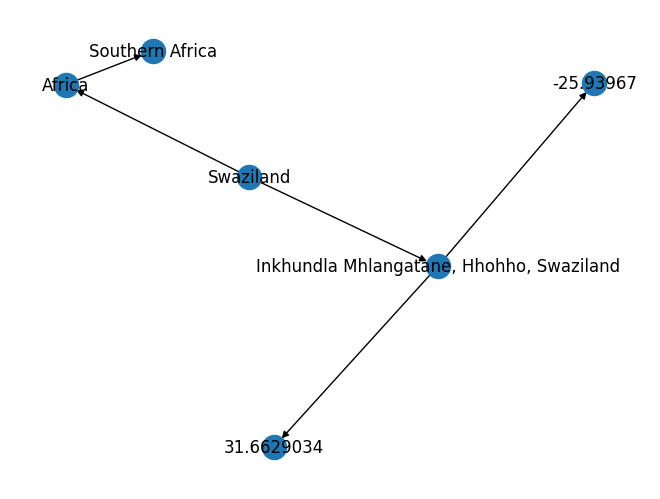

In [61]:
# Example usage
G = create_knowledge_graph(train_df[:1])
nx.draw(G, with_labels=True)
plt.show()


In [62]:
import torch
torch_ver = torch.__version__
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch_ver}.html
  !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch_ver}.html
  !pip install -q torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git
  !pip install -q transformers

  Preparing metadata (setup.py) ... done


# Generate embeddings

### Embedding

In [85]:
from transformers import DistilBertTokenizer, DistilBertModel
from concurrent.futures import ThreadPoolExecutor, as_completed
from queue import Queue
from threading import Thread
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import networkx as nx
import numpy as np
from tqdm import tqdm



def generate_kge_with_distilbert(graph):
    # Initialize DistilBERT tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
    model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

    # Dictionary to store embeddings
    node_embeddings = {}

    # Generate embeddings for each node
    for node in graph.nodes():
        # Convert node to text (assuming the node is already in string format or convertible to string)
        node_text = str(node)

        # Tokenize and generate output
        inputs = tokenizer(node_text, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs)

        # Extract the hidden state for the [CLS] token (first token)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().detach().numpy()

        # Store the embedding
        node_embeddings[node] = cls_embedding

    return node_embeddings


In [86]:
train_emb = generate_kge_with_distilbert(train_kg)
val_emb = generate_kge_with_distilbert(val_kg)
test_emb = generate_kge_with_distilbert(test_kg)

In [ ]:
val_emb['Ukraine']

In [65]:
val_emb.keys()

dict_keys(['Croatia', 'Klek, Dubrovnik-Neretva, Croatia', 42.9455874, 17.5633131, 'Europe', 'Southern Europe', 'Papua New Guinea', 'Ayate, New Guinea', -4.0539161, 136.3547156, 'Oceania', 'Melanesia', 'Cayman Islands', 'Tulip Close, Grand Cayman, Cayman Islands', 19.3839486, -81.399913, 'Americas', 'Caribbean', 'Mauritius', 'Brown Sequard Street, Plaines Wilhems, Mauritius', -20.3235093, 57.5235259, 'Africa', 'Eastern Africa', 'Saint Martin', 'Impasse des Violenes, Saint Martin', 18.0772043, -63.0695667, 'Ukraine', 'Тунель, Zmiiv Raion, Kharkiv Oblast, Ukraine', 49.5903937, 36.5140179, 'Eastern Europe', 'Azerbaijan', 'Jafar Jabbarly, Sumgayit, Sumqayıt İnzibati Ərazisi, Azerbaijan', 40.5829764, 49.6758711, 'Asia', 'Western Asia', 'Romania', 'Strada Orhideei, Lupeni, Hunedoara, Romania', 45.345921, 23.1898889, 'Palestinian Territory', 'Temraz St, Rafah Governorate, Gaza Strip, Palestinian Territories', 31.2556914, 34.2876053, 'Luxembourg', 'Rue Principale, Wormeldange, Canton Grevenmach

# Extract labels and other data

#### Extract data from Graph

In [87]:
def extract_data_from_graph(graph):
    # Initialize dictionaries
    country_labels = []
    location_longitude = []
    location_latitude = []
    node_types = []
    node_type_to_int = {}
    type_counter = 0
    # Collect unique node types from the graph
    unique_node_types = set(graph.nodes[node].get('type', 'Unknown') for node in graph.nodes)
    node_type_to_int = {node_type: i for i, node_type in enumerate(sorted(unique_node_types))}

    for node, data in graph.nodes(data=True):
        node_type = data.get('type', 'Unknown')
        node_types.append(node_type_to_int.get(node_type, 0))
        # Extract country labels if available
        if data.get('type') == 'Country':
            country_labels.append(node)
        # Extract location coordinates if available
        elif data.get('type') == 'Location_Longitude':
            location_longitude.append(node)
        elif data.get('type') == 'Location_Latitude':
            location_latitude.append(node)


    unique_countries = list(set(country_labels))
    country_to_int = {country: i for i, country in enumerate(unique_countries)}
    country_labels = [country_to_int[name] for name in country_labels]

    return {
            'country_labels':country_labels,
            'location_latitudes':location_latitude,
            'location_longitudes':location_longitude,
            'node_types':node_types,
            'node_type_to_int':node_type_to_int
            }



In [88]:
labels_train = extract_data_from_graph(train_kg)
labels_val = extract_data_from_graph(val_kg)
labels_test = extract_data_from_graph(test_kg)

In [72]:
labels_train['node_type_to_int']

{'Country': 0,
 'Location': 1,
 'Location_Latitude': 2,
 'Location_Longitude': 3,
 'Region': 4,
 'Sub_Region': 5}

# Create PyG dataset

In [89]:
import torch
from torch_geometric.data import Data, Dataset

class CustomDataset(Dataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

def create_pyg_dataset(graph, embeddings, labels):
    data_list = []

    # Create a mapping from node to index
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}

    # Create edge index tensor
    edge_index = []
    for edge in graph.edges():
        src, dst = edge
        edge_index.append((node_to_idx[src], node_to_idx[dst]))
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create node feature tensor from embeddings
    num_nodes = len(graph.nodes())
    embedding_dim = next(iter(embeddings.values())).shape[0]
    x = torch.zeros(num_nodes, embedding_dim)
    for node, idx in node_to_idx.items():
        x[idx] = torch.tensor(embeddings[node], dtype=torch.float)

    # Create label tensors
    y = torch.zeros(num_nodes, 2)  # Assuming 2D coordinates (latitude, longitude)

    for node, idx in node_to_idx.items():
        if labels.get(node):
            y[idx] = torch.tensor(labels[node], dtype=torch.float)

    # Create PyG data object
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

    return CustomDataset(data_list)



In [92]:
train_dataset = create_pyg_dataset(train_kg, train_emb, labels_train)
val_dataset = create_pyg_dataset(val_kg, val_emb, labels_val)
test_dataset = create_pyg_dataset(test_kg, test_emb, labels_test)

# Model

In [93]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.fc(x)

        return x

#


# Training

In [94]:
# Assume dataset is your PyG dataset and it has been split into train_dataset, val_dataset, and test_dataset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Initialize the model, optimizer, and other settings
num_features = train_dataset.num_features
num_classes = 2  # For latitude and longitude


model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()  # Mean Squared Error Loss

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


TypeError: ignored

In [ ]:
# Initialize the model, optimizer, and other settings
num_features = kge_data_train.num_features
num_classes = 2  # For latitude and longitude
model = GCN(num_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loader = DataLoader(kge_data_train, batch_size=32, shuffle=True)

# Training loop
for epoch in range(200):
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.y)  # Using Mean Squared Error loss for regression
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

In [ ]:


# Validation function
def validate(loader):
    model.eval()
    val_loss = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        loss = criterion(out, data.y)
        val_loss += loss.item() * data.num_graphs

    return val_loss / len(loader.dataset)

# Test function
def test(loader):
    model.eval()
    test_loss = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        loss = criterion(out, data.y)
        test_loss += loss.item() * data.num_graphs

    return test_loss / len(loader.dataset)